## Time series prediction

For my second capstone, I chose to work on the [Kaggle web traffic time series forcasting competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting). The competition goal is to use data on the number of visits to approximately 145,000 Wikipedia articles to predict the number of visits those same articles will recieve over the next two months. Clients potentially interested in prediction methods for this problem include web-based companies or advertisers that want to predict future visits for planning purposes. Time series prediction could also have important applications in many other domains, so methods that perform well in this problem may be interesting to a broad client base.

To predict future wikipedia visits, I use time series of visits for previous days for each series that I wish to predict on:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

time_train_full = pd.read_csv("train_2_final.csv")
time_test = time_train_full.iloc[:, -62:].assign(Page = time_train_full.loc[:, "Page"])
time_train = time_train_full.iloc[:, -72:-62].assign(Page = time_train_full.loc[:, "Page"])
time_train.head()

,2017-07-01,2017-07-02,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-08,2017-07-09,2017-07-10,Page
0,23.0,24.0,26.0,15.0,14.0,15.0,19.0,29.0,22.0,25.0,2NE1_zh.wikipedia.org_all-access_spider
1,15.0,26.0,16.0,23.0,19.0,16.0,816.0,20.0,76.0,24.0,2PM_zh.wikipedia.org_all-access_spider
2,1.0,1.0,7.0,1.0,1.0,1.0,10.0,1.0,2.0,6.0,3C_zh.wikipedia.org_all-access_spider
3,7.0,19.0,16.0,10.0,17.0,15.0,22.0,6.0,6.0,18.0,4minute_zh.wikipedia.org_all-access_spider
4,12.0,16.0,6.0,16.0,18.0,12.0,14.0,11.0,16.0,15.0,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...


While exploring methods the predict future values of each time series, I came to realize that a very simple method, taking the median of each time series over a window of recent values, can acutally perform quite well, and possible could be a useful feature for prediction. Here I plot the log median values in a ten day window against the observed log visits for the next 62 days:

/Users/scottpiraino/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/scottpiraino/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


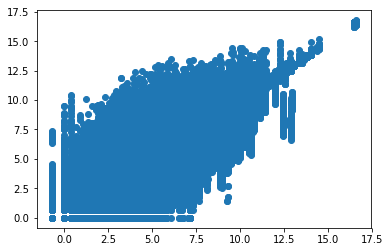

In [2]:
time_train_median = time_train.median(axis = 1, skipna = True).fillna(0)
time_test_melt = pd.melt(time_test, id_vars = ["Page"])
time_train_median_frame = time_train.loc[:, "Page"].to_frame(name = "Page").assign(page_median = time_train_median)
time_test_melt_join = time_test_melt.merge(time_train_median_frame, on = "Page", how = "left")
page_median_log = time_test_melt_join.loc[:, "page_median"]
page_median_log[page_median_log == 0] = 1
page_median_log = np.log(page_median_log.values)
page_observed_log = time_test_melt_join.loc[:, "value"]
page_observed_log[page_observed_log == 0] = 1
page_observed_log = np.log(page_observed_log.values)
plt.scatter(page_median_log, page_observed_log)

The median is highly correlated with the future values of its associated time series, suggesting that it may be a useful feature for prediction.

In addition to looking at the median as a possible feature, I also used the time series prediction software prophet to make predictions for future values of each time series (see code for prophet prediction [here](https://github.com/ScottWPiraino/Springboard_Data_Science/blob/master/Capstone_2/kaggle_time_series_prophet_all_series.ipynb). I now load those predictions:

In [3]:
prophet_final = pd.read_csv("kaggle_time_train_prophet_results_all_series_train.csv").dropna()
prophet_final.loc[prophet_final["yhat"] < 0, "yhat"] = 0
prophet_final.head()

,ds,yhat,series_name,observed_y,y_median
0,2017-05-10,27.838235,2NE1_zh.wikipedia.org_all-access_spider,16.0,21.5
1,2017-05-11,25.479508,2NE1_zh.wikipedia.org_all-access_spider,22.0,21.5
2,2017-05-12,27.605868,2NE1_zh.wikipedia.org_all-access_spider,22.0,21.5
3,2017-05-13,28.031390,2NE1_zh.wikipedia.org_all-access_spider,23.0,21.5
4,2017-05-14,27.714642,2NE1_zh.wikipedia.org_all-access_spider,21.0,21.5


This dataframe contains prophet forcasts and medians of previous 30 days for the last 124th through 62nd days of each time series. Since the task of the Kaggle competition is to predict the number of visits for the 62 days post submission, I use the data above to test the performance of the median and prophet predictions on held-out days that span the same time span post prediction (62 days), while leaving another 62 day interval at the end of the series for any subsequent validation. Below I plot scatter plots of the prophet predictions and median against the observed number of visits:

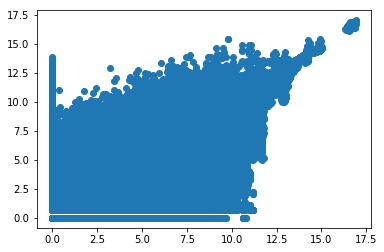

In [4]:
plt.scatter(np.log(prophet_final["yhat"] + 1), np.log(prophet_final["observed_y"] + 1))

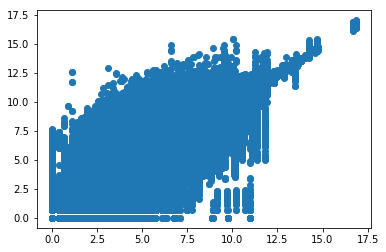

In [5]:
plt.scatter(np.log(prophet_final["y_median"] + 1), np.log(prophet_final["observed_y"] + 1))

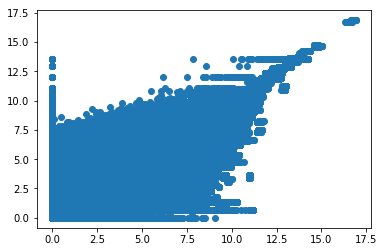

In [6]:
plt.scatter(np.log(prophet_final["yhat"] + 1), np.log(prophet_final["y_median"] + 1))

The median feature and prophet predictions are both positively associated with the observed visit counts, as well as positively associated with each other. This suggests that both could be useful features for prediction. To evaluate to what extent this is the case and also to acheive a more strongly predictive model for the objective loss function used for the competition, I fit a linear model with both the median and prophet predictions as features (plus an intercept term). I also implement a fitting procedure that uses a custom loss function, which is used for evaluation during the competition. I fit the linear model with both features and look at the resulting coefficients: 

In [7]:
def time_predict(weights):
    lin_predictor = weights[0] * prophet_final["yhat"].values + weights[1] * prophet_final["y_median"].values + weights[2]
    time_prediction = np.rint(lin_predictor)
    return(time_prediction)

# SMAPE score. Adapts code from https://www.kaggle.com/cpmpml/smape-weirdness
def smape_loss(weights):
    y_pred = time_predict(weights)
    y_true = prophet_final["observed_y"].values
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return(np.nanmean(diff))

In [8]:
res_lin = minimize(smape_loss, np.array([1.0, 1.0, 0.0]), method = "Nelder-Mead", tol=1e-6)
res_lin["x"]

/Users/scottpiraino/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


array([  7.34226519e-07,   8.99672322e-01,   1.36200020e-03])

The first coefficient is for the prophet predictions, the second for the median feature, and the last is an intercept. The coefficient for the median is positive, suggesting that a higher median number of visists in previous days is predictive of higher visits in subsequent days. The coefficient for the prophet prediction is positive, but much smaller than the coefficient for the median. Both of the two feature are on roughly the same scales, so a smaller coefficient for the prophet predictions suggest that they play much less of a role in  this model than the median feature. This is perhaps surprising, but from looking at discussions on the Kaggle forums, many teams competing in this competition found that models that use the median or slight variations are some of the highest performing models. It is worth mentioning that this result isn't solely because the prophet predictions are uninformative, as fitting this linear model with only that feature shows:

In [9]:
def time_predict(weights):
    lin_predictor = weights[0] * prophet_final["yhat"].values  + weights[1]
    time_prediction = np.rint(lin_predictor)
    return(time_prediction)

# SMAPE score. Adapts code from https://www.kaggle.com/cpmpml/smape-weirdness
def smape_loss(weights):
    y_pred = time_predict(weights)
    y_true = prophet_final["observed_y"].values
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return(np.nanmean(diff))

In [10]:
res_lin_2 = minimize(smape_loss, np.array([1.0, 0.0]), method = "Nelder-Mead", tol=1e-6)
res_lin_2["x"]

/Users/scottpiraino/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


array([ 0.8031113 ,  0.00105347])

This suggests that the prophet predictions and median may carry much of the same information, and in the linear model with both included, the prophet predictions may serve more as a refinement to the predictions, while the median term has the largest impact.